In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc
import pdvega

In [22]:
bchunk = pd.read_csv('/home/marnec/Projects/CAID/baseline/len-negs_new-disprot-linker_chunk_scores.csv', index_col=[0]).mean().to_frame().transpose()
bchain = pd.read_csv('/home/marnec/Projects/CAID/baseline/len-negs_new-disprot-linker_chain_scores.csv', index_col=[0]).mean().to_frame().transpose()
bcons = pd.read_csv('/home/marnec/Projects/CAID/baseline/len-negs_new-disprot-linker_cons_scores.csv', index_col=[0]).mean().to_frame().transpose()
bs = pd.concat([bchunk, bchain, bcons], axis=0, sort=False)
bs.index = ['chunk', 'chain', 'cons']
bs.round(3)

,BAc,FPR,F1s,F1s_n,MCC,Pre,Pre_n,Rec,Rec_n,BAc_avg,...,Pre_std,Pre_n_avg,Pre_n_std,Rec_avg,Rec_std,Rec_n_avg,Rec_n_std,AUC_PRC,AUC_ROC,Cov
chunk,0.566,0.067,0.198,0.933,0.131,0.198,0.933,0.198,0.933,0.500,...,0.118,0.112,0.052,0.118,0.112,0.118,0.112,NaN,NaN,NaN
chain,0.501,0.077,0.080,0.923,0.003,0.080,0.923,0.080,0.923,0.502,...,0.054,0.067,0.052,0.122,0.111,0.059,0.014,NaN,NaN,NaN
cons,0.559,0.847,0.160,0.265,0.090,0.087,0.981,0.965,0.153,0.563,...,0.179,0.220,0.121,0.135,0.035,0.163,0.175,0.088,0.756,1.0


In [28]:
df = pd.read_csv('/home/marnec/Projects/CAID/test/new-disprot-linker_redefScores.csv', index_col=[0])
df = df.append(bs, sort=False).round(3)
df

,BAc,FPR,F1s,F1s_n,MCC,Pre,Pre_n,Rec,Rec_n,BAc_avg,...,Pre_std,Pre_n_avg,Pre_n_std,Rec_avg,Rec_std,Rec_n_avg,Rec_n_std,Cov,AUC_PRC,AUC_ROC
D002_cheng_predisorder,0.759,0.300,0.303,0.817,0.292,0.186,0.979,0.818,0.700,0.702,...,0.278,0.151,0.286,0.255,0.036,0.373,0.202,1.0,NaN,NaN
D011_jones_disopred3_disorder,0.728,0.336,0.273,0.790,0.252,0.165,0.974,0.792,0.664,0.688,...,0.277,0.200,0.286,0.298,0.055,0.410,0.257,1.0,NaN,NaN
D028_zhou_spot-disorder1,0.756,0.413,0.270,0.737,0.275,0.158,0.989,0.926,0.587,0.737,...,0.270,0.294,0.251,0.245,0.026,0.300,0.290,1.0,NaN,NaN
D029_zhou_spot-disorder2,0.791,0.288,0.365,0.826,0.352,0.231,0.982,0.869,0.712,0.775,...,0.282,0.179,0.262,0.271,0.034,0.311,0.220,1.0,NaN,NaN
D030_zhou_spot-disorder-single,0.745,0.363,0.276,0.772,0.267,0.165,0.981,0.852,0.637,0.664,...,0.259,0.252,0.260,0.220,0.040,0.370,0.274,1.0,NaN,NaN
chunk,0.566,0.067,0.198,0.933,0.131,0.198,0.933,0.198,0.933,0.500,...,0.118,0.112,0.052,0.118,0.112,0.118,0.112,NaN,NaN,NaN
chain,0.501,0.077,0.080,0.923,0.003,0.080,0.923,0.080,0.923,0.502,...,0.054,0.067,0.052,0.122,0.111,0.059,0.014,NaN,NaN,NaN
cons,0.559,0.847,0.160,0.265,0.090,0.087,0.981,0.965,0.153,0.563,...,0.179,0.220,0.121,0.135,0.035,0.163,0.175,1.0,0.088,0.756


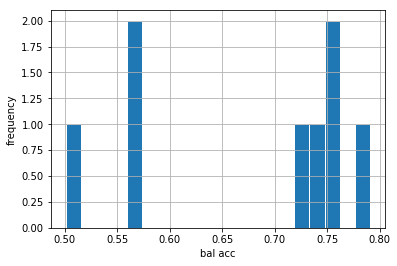

In [27]:
ax = df['BAc'].hist(bins=20, edgecolor='w')
ax.set_xlabel('bal acc')
ax.set_ylabel('frequency');

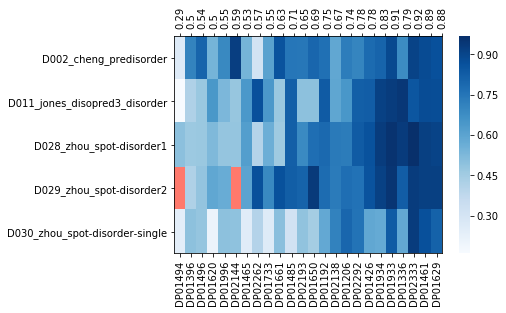

In [123]:
pi = pd.read_csv('/home/marnec/Projects/CAID/test/new-disprot-linker_perInstanceScores.csv', header=[0], index_col=[0, 1])
piba = pi.xs('bal_acc', level=1).reindex(pi.mean().sort_values().index, axis=1)
ax = sns.heatmap(piba, cmap='Blues')
ax.axes.get_yaxis().get_label().set_visible(False)
ax.set_facecolor('xkcd:salmon')

ax2 = ax.twiny()
ax2tick_location = ax.xaxis.get_ticklocs() #Get the tick locations in data coordinates as a numpy array
ax2.set_xticks(ax2tick_location)
ax2.set_xticklabels(piba.mean().round(2));
ax2.tick_params(axis='x', rotation=90)

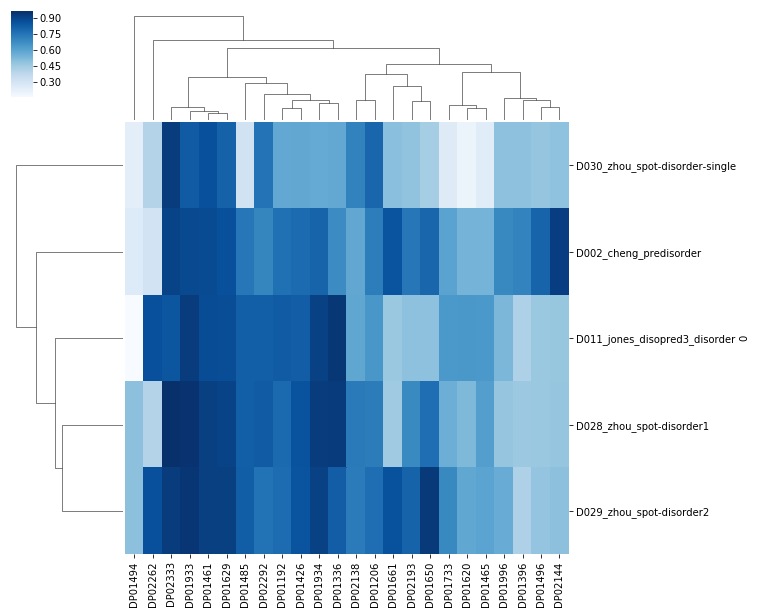

In [54]:
sns.clustermap(pi.xs('bal_acc', level=1).reindex(pi.mean().sort_values().index, axis=1).fillna(0.5), cmap="Blues");

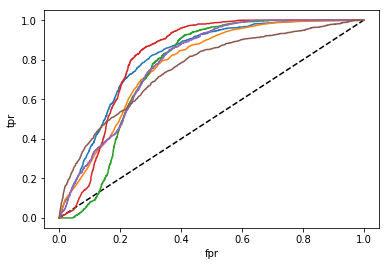

In [126]:
def parse_curve_file(curve_file):
    with open(curve_file) as f:
        for line in f:
            code, _, auc, *points = line.split()
            auc = float(auc)
            x, y, thr = zip(*map(lambda s: map(float, s.split(',')), points))

            yield code, auc, np.array(x), np.array(y), np.array(thr)

# initialize a figure and an ax            
fig, ax = plt.subplots()
# plot diagonal
ax.plot([0, 1], [0, 1], linestyle='--', color='k')

# plot all curves in evaluation file
for curve_data in parse_curve_file('/home/marnec/Projects/CAID/test/new-disprot-linker_rocPoints.txt'):
    code, auc_roc, x, y, thr = curve_data
    ax.plot(x, y, label='{} AUC: {:.2f}'.format(code, auc_roc))

# plot baseline curve from its own file
for curve_data in parse_curve_file('/home/marnec/Projects/CAID/baseline/len-negs_new-disprot-linker_cons_rocPoints.txt'):
    code, auc_roc, x, y, thr = curve_data
    ax.plot(x, y, label='{} AUC: {:.2f}'.format(code, auc_roc))

ax.set_xlabel('fpr')
ax.set_ylabel('tpr');

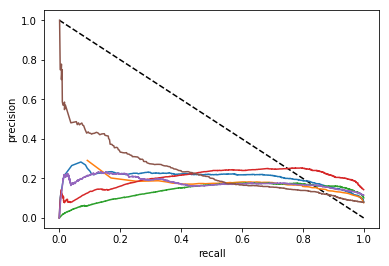

In [128]:
# initialize a figure and an ax            
fig, ax = plt.subplots()
# plot diagonal
ax.plot([0, 1], [1, 0], linestyle='--', color='k')

# plot all curves in evaluation file
for i, curve_data in enumerate(parse_curve_file('/home/marnec/Projects/CAID/test/new-disprot-linker_prcPoints.txt')):
    code, auc_prc, x, y, thr = curve_data
    ax.plot(x, y, label='{} AUC: {:.2f}'.format(code, auc_prc))

# plot baseline curve from its own file
for curve_data in parse_curve_file('/home/marnec/Projects/CAID/baseline/len-negs_new-disprot-linker_cons_prcPoints.txt'):
    code, auc_prc, x, y, thr = curve_data
    ax.plot(x, y, label='{} AUC: {:.2f}'.format(code, auc_prc))

ax.set_xlabel('recall')
ax.set_ylabel('precision');

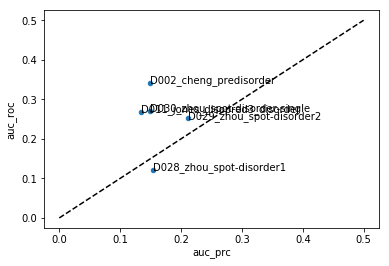

In [131]:
roc = list()
prc = list()
for roc_data in parse_curve_file('/home/marnec/Projects/CAID/test/new-disprot-linker_rocPoints.txt'):
    code, aucs, x, y, thr = roc_data
    auc_roc = auc(x[x<=0.2], y[x<=0.2])
    auc_roc /= 0.2
    roc.append([code, auc_roc])
    
for prc_data in parse_curve_file('/home/marnec/Projects/CAID/test/new-disprot-linker_prcPoints.txt'):
    code, aucs, x, y, thr = prc_data
    auc_prc = auc(x[x>=0.8], y[x>=0.8])
    auc_prc /= 0.2
    prc.append([code, auc_prc])

roc = pd.DataFrame(roc, columns=['code', 'auc_roc']).set_index('code')
prc = pd.DataFrame(prc, columns=['code', 'auc_prc']).set_index('code')

sc = pd.concat([prc, roc], axis=1)
ax = sc.plot.scatter(x='auc_prc', y='auc_roc')

for k, v in sc.iterrows():
    ax.annotate(k, v)
    
ax = ax.plot([0, 0.5], [0, 0.5], color='k', linestyle='--')

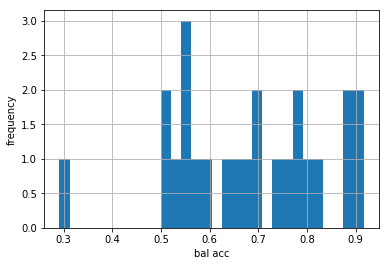

In [129]:
ax = pi.xs('bal_acc', level=1).mean().hist(bins=30)
ax.set_xlabel('bal acc')
ax.set_ylabel('frequency');